In [1]:
import numpy as np
import pandas as pd

import scanpy as sc
from collections import Counter
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from tqdm.auto import tqdm

/data1/chenyx/anaconda3/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from numba import set_num_threads

set_num_threads(16)

In [3]:
import anndata as ad

# Load raw data

In [39]:
adata_merged = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Lung_atlas_uniformed.h5ad")
adata_merged.var['gene_symbol'] = adata_merged.var.index

In [40]:
adata_merged

AnnData object with n_obs × n_vars = 32472 × 42117
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    var: 'gene_symbol'

In [41]:
adata_merged.obs.batch.unique()

['B1', 'B2', 'B3', 'B4', 'A6', ..., '2', '4', '3', '1', '6']
Length: 16
Categories (16, object): ['1', '2', '3', '4', ..., 'B1', 'B2', 'B3', 'B4']

In [42]:
adata_merged.obs.sampling_method.unique()

['Transplant', 'Biopsy']
Categories (2, object): ['Biopsy', 'Transplant']

# Process without integration

In [43]:
adata_merged.raw = adata_merged.copy()
sc.pp.normalize_total(adata_merged,target_sum=1e4)
sc.pp.log1p(adata_merged)

In [44]:
adata_merged = adata_merged[:,pd.read_csv("../gene_list.csv",index_col=0)['gene_name']]

In [45]:
adata_merged

View of AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    var: 'gene_symbol'
    uns: 'log1p'

In [46]:
adata_merged.write_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/raw.h5ad")

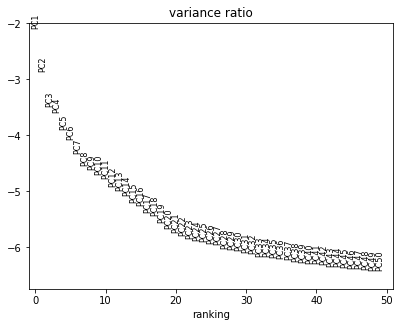

In [47]:
# PCA
sc.tl.pca(adata_merged, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_merged, n_pcs=50, log=True)

In [48]:
sc.pp.neighbors(adata_merged, n_pcs=30)
sc.tl.umap(adata_merged)

/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/

In [ ]:
sc.set_figure_params(dpi=300)
fig = sc.pl.umap(adata_merged, color=['cell_type', 'batch'],return_fig=True,legend_fontsize='xx-small',ncols=1)
fig.set_size_inches(8, 8)
fig.savefig("Integration_results_Lung/Raw.results.png", bbox_inches='tight')

In [54]:
adata_merged.write_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/merged_result.h5ad")

# BBKNN

In [56]:
adata_BBKNN = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/raw.h5ad")

In [57]:
import time

In [59]:
start_time = time.time()
# PCA
sc.tl.pca(adata_BBKNN, svd_solver='arpack')

import bbknn
bbknn.bbknn(adata_BBKNN, batch_key='batch')

sc.tl.umap(adata_BBKNN)
end_time = time.time()

/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


In [60]:
print(end_time-start_time)

36.85404086112976


In [ ]:
sc.set_figure_params(dpi=300)
fig = sc.pl.umap(adata_BBKNN, color=['cell_type', 'batch'],return_fig=True,legend_fontsize='xx-small',ncols=1)
fig.set_size_inches(8, 8)
fig.savefig("Integration_results_Lung/BBKNN.results.png", bbox_inches='tight')

In [62]:
adata_BBKNN.write_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/BBKNN_result.h5ad")

# harmony

In [63]:
import scanpy.external as sce

In [65]:
adata_harmony = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/raw.h5ad")

In [66]:
adata_harmony

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    var: 'gene_symbol'
    uns: 'log1p'

In [68]:
start_time = time.time()

# PCA
sc.tl.pca(adata_harmony, svd_solver='arpack')
# harmony
sce.pp.harmony_integrate(adata_harmony, 'batch')

sc.pp.neighbors(adata_harmony, use_rep='X_pca_harmony')
sc.tl.umap(adata_harmony)

end_time = time.time()

2023-12-27 23:46:07,769 - harmonypy - INFO - Iteration 1 of 10
2023-12-27 23:46:14,724 - harmonypy - INFO - Iteration 2 of 10
2023-12-27 23:46:20,684 - harmonypy - INFO - Iteration 3 of 10
2023-12-27 23:46:26,225 - harmonypy - INFO - Iteration 4 of 10
2023-12-27 23:46:31,783 - harmonypy - INFO - Converged after 4 iterations


In [69]:
end_time-start_time

53.77822923660278

In [ ]:
sc.set_figure_params(dpi=300)
fig = sc.pl.umap(adata_harmony, color=['cell_type', 'batch'],return_fig=True,legend_fontsize='xx-small',ncols=1)
fig.set_size_inches(8, 8)
fig.savefig("Integration_results_Lung/harmony.results.png", bbox_inches='tight')

In [71]:
adata_harmony.write_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/harmony.h5ad")

# scVI without Annotation

In [4]:
import scvi

/data1/chenyx/anaconda3/envs/scvi/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/data1/chenyx/anaconda3/envs/scvi/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [5]:
adata_scVI = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/raw.h5ad")
adata_scVI = adata_scVI.raw.to_adata()
adata_scVI = adata_scVI[:,pd.read_csv("../gene_list.csv",index_col=0)['gene_name']]

In [13]:
adata_scVI = adata_scVI.copy()

In [14]:
scvi.model.SCVI.setup_anndata(adata_scVI, batch_key="batch")

/data1/chenyx/anaconda3/envs/scvi/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
/data1/chenyx/anaconda3/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [15]:
vae = scvi.model.SCVI(adata_scVI, n_layers=2, n_latent=30, gene_likelihood="nb")

In [16]:
vae.train(use_gpu=1)

/data1/chenyx/anaconda3/envs/scvi/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 1/246:   0%|          | 0/246 [00:00<?, ?it/s]

/data1/chenyx/anaconda3/envs/scvi/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 246/246: 100%|██████████| 246/246 [09:36<00:00,  2.28s/it, v_num=1, train_loss_step=483, train_loss_epoch=462]

`Trainer.fit` stopped: `max_epochs=246` reached.


Epoch 246/246: 100%|██████████| 246/246 [09:36<00:00,  2.34s/it, v_num=1, train_loss_step=483, train_loss_epoch=462]


In [17]:
adata_scVI.obsm["X_scVI"] = vae.get_latent_representation()

In [18]:
sc.pp.neighbors(adata_scVI, use_rep="X_scVI")
sc.tl.umap(adata_scVI)

In [ ]:
sc.set_figure_params(dpi=300)
fig = sc.pl.umap(adata_scVI, color=['cell_type', 'batch'],return_fig=True,legend_fontsize='xx-small',ncols=1)
fig.set_size_inches(8, 8)
fig.savefig("Integration_results_Lung/scVI.results.png", bbox_inches='tight')

In [20]:
adata_scVI.write_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/scVI.h5ad")

In [21]:
vae.save("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/scVI_model.pt")

# scANVI

In [22]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata_scVI,
    labels_key="cell_type",
    unlabeled_category="Unclassified",
)

/data1/chenyx/anaconda3/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [25]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100,use_gpu=1)

INFO     Training for 20 epochs.                                                                                   


/data1/chenyx/anaconda3/envs/scvi/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 20/20: 100%|██████████| 20/20 [02:15<00:00,  6.82s/it, v_num=1, train_loss_step=562, train_loss_epoch=540]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [02:15<00:00,  6.77s/it, v_num=1, train_loss_step=562, train_loss_epoch=540]


In [29]:
adata_scVI.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata_scVI)
adata_scVI.obsm["X_scANVI_MDE"] = scvi.model.utils.mde(adata_scVI.obsm["X_scANVI"])

In [ ]:
sc.set_figure_params(dpi=300)
fig = sc.pl.embedding(
    adata_scVI, basis="X_scANVI_MDE", color=['cell_type', 'batch'],return_fig=True,legend_fontsize='xx-small',ncols=1)
fig.set_size_inches(8, 8)
fig.savefig("Integration_results_Lung/scANVI.results.png", bbox_inches='tight')

In [31]:
adata_scVI.write_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/scANVI.h5ad")

# Seurat integrated

In [32]:
adata_seurat = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/Seurat_result.h5ad")

In [33]:
adata_seurat

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    var: 'gene_name'

In [34]:
sc.pp.pca(adata_seurat)

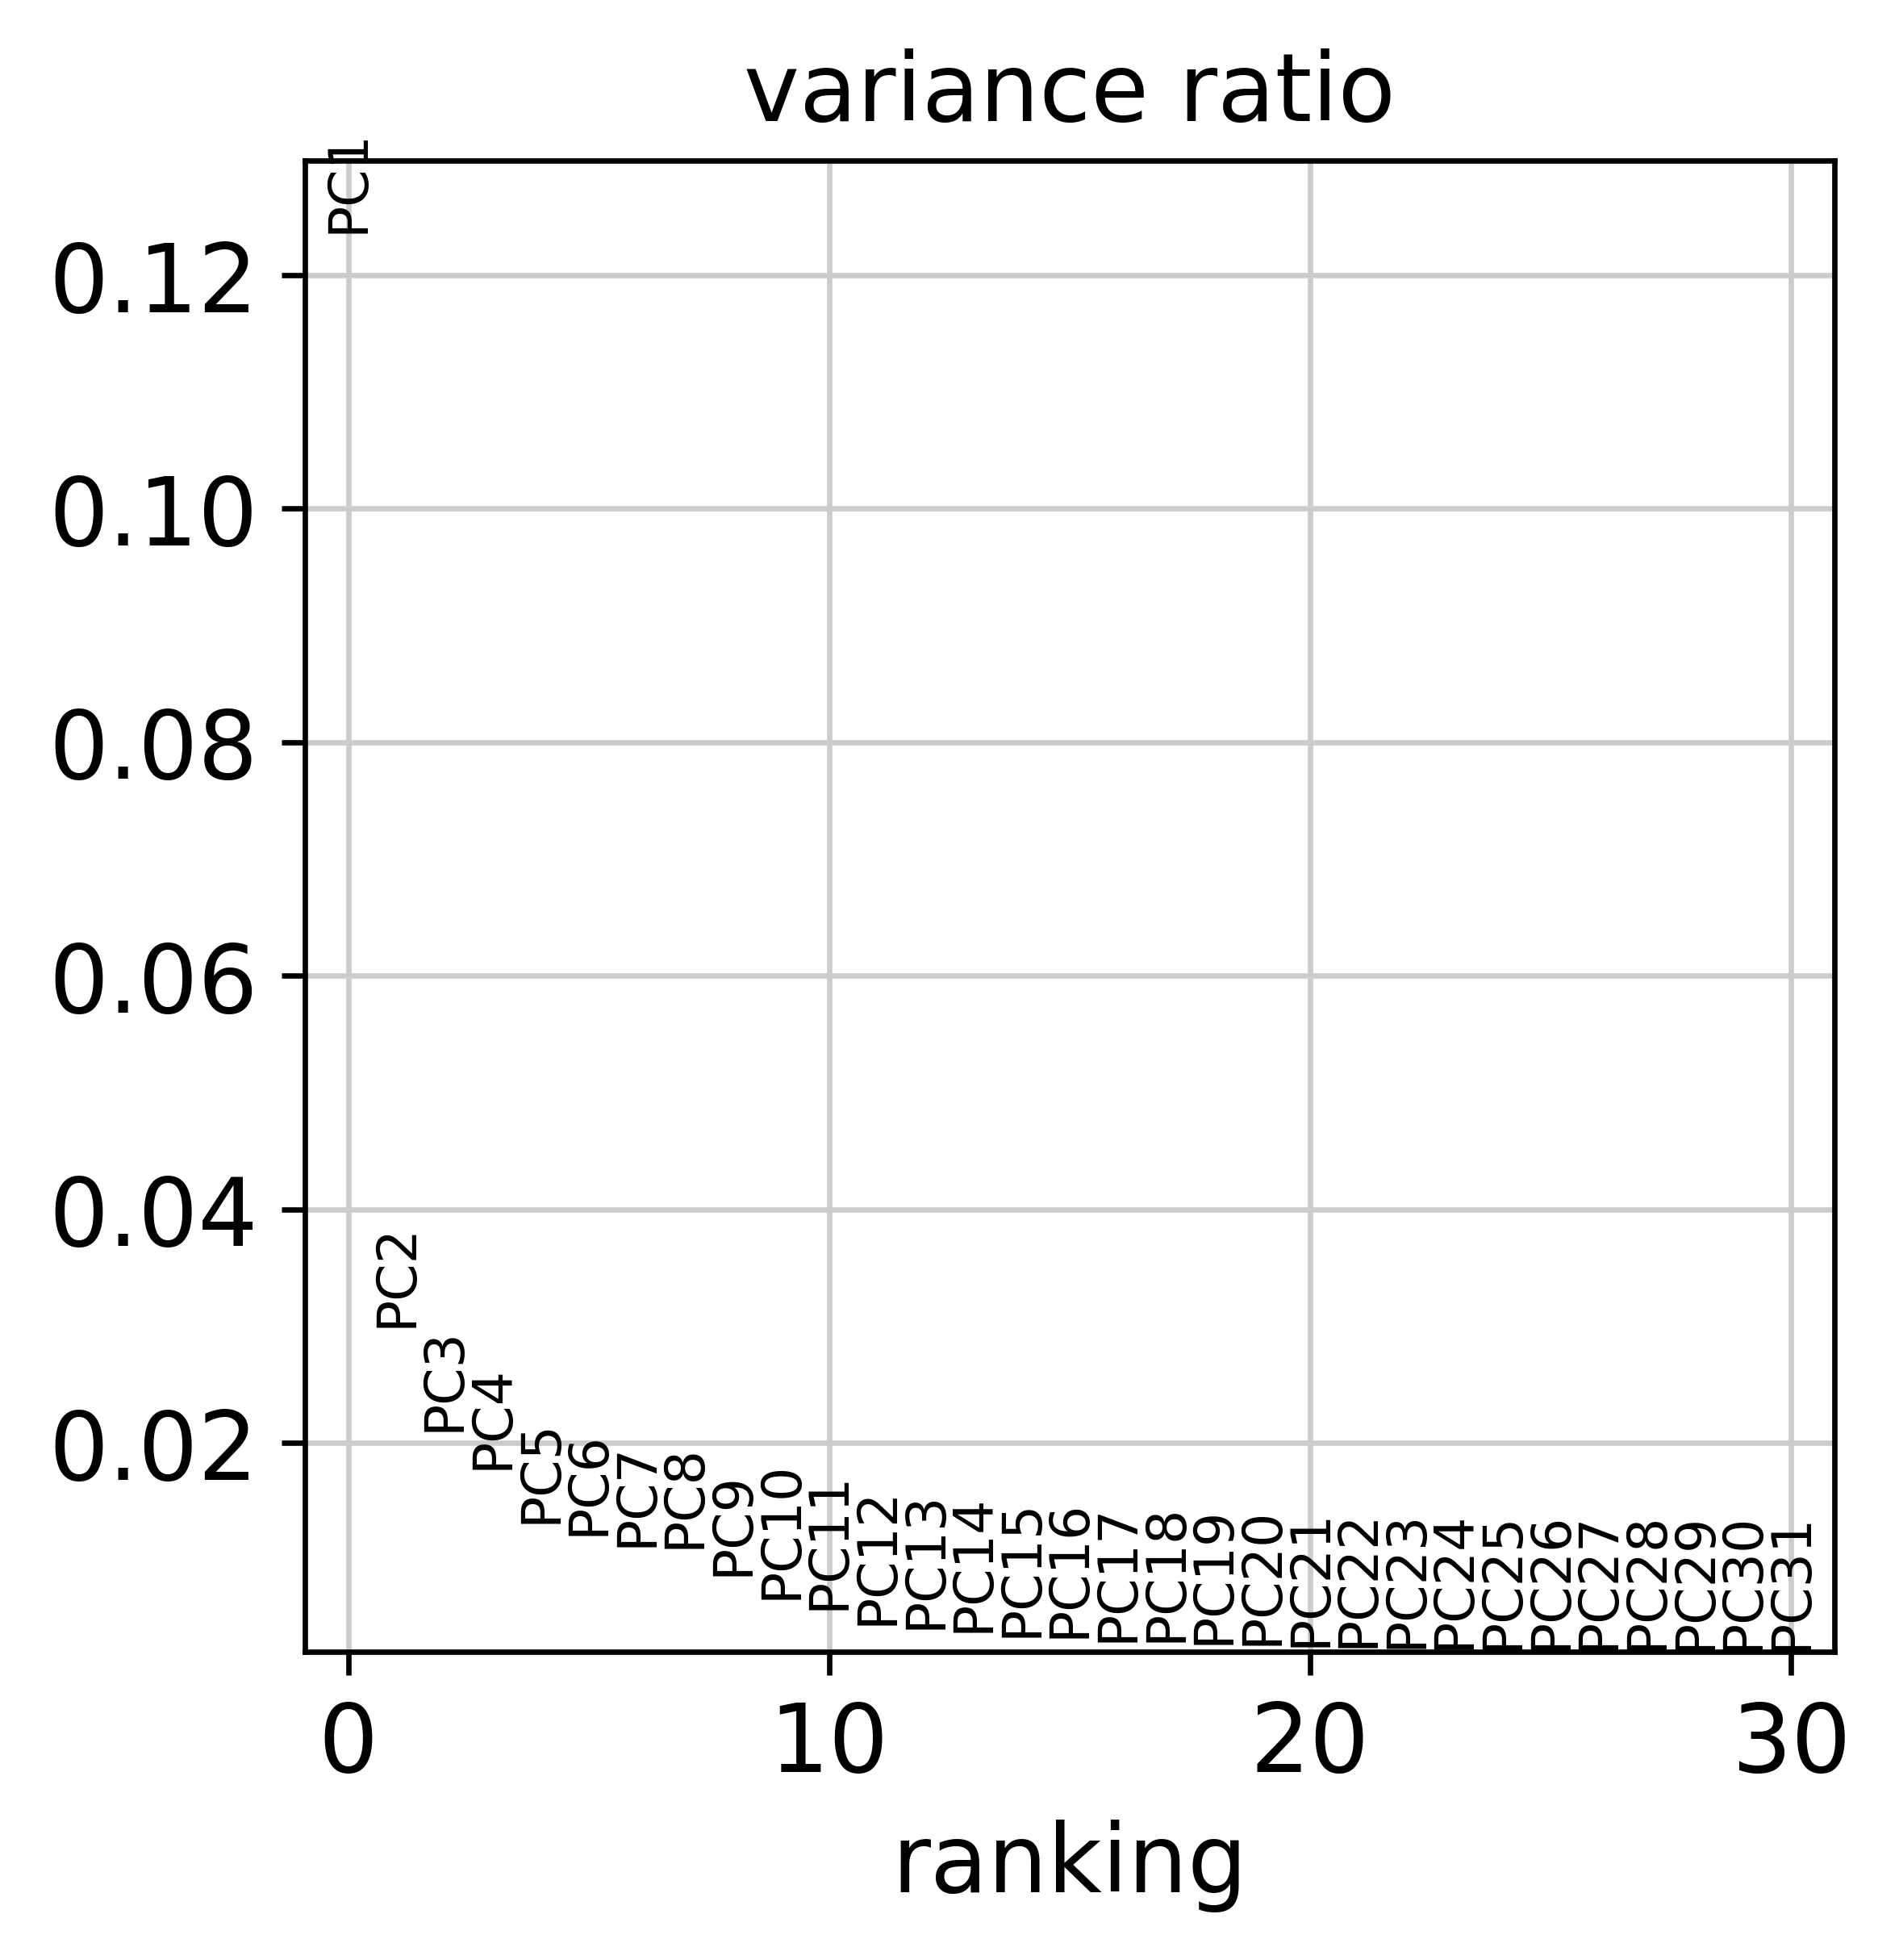

In [35]:
sc.pl.pca_variance_ratio(adata_seurat)

In [36]:
sc.pp.neighbors(adata_seurat,n_pcs=10)
sc.tl.umap(adata_seurat)

In [ ]:
sc.set_figure_params(dpi=300)
fig = sc.pl.umap(
    adata_seurat,  color=['cell_type', 'batch'],return_fig=True,legend_fontsize='xx-small',ncols=1)
fig.set_size_inches(8, 8)
fig.savefig("Integration_results_Lung/Seurat.results.png", bbox_inches='tight')

In [38]:
adata_seurat.write_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/Seurat_result.h5ad")

# FastMNN

In [39]:
adata_fastmnn = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/FastMNN_result.h5ad")

In [40]:
adata_fastmnn

AnnData object with n_obs × n_vars = 32472 × 1650
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    var: 'gene_name'

In [42]:
sc.pp.pca(adata_fastmnn)

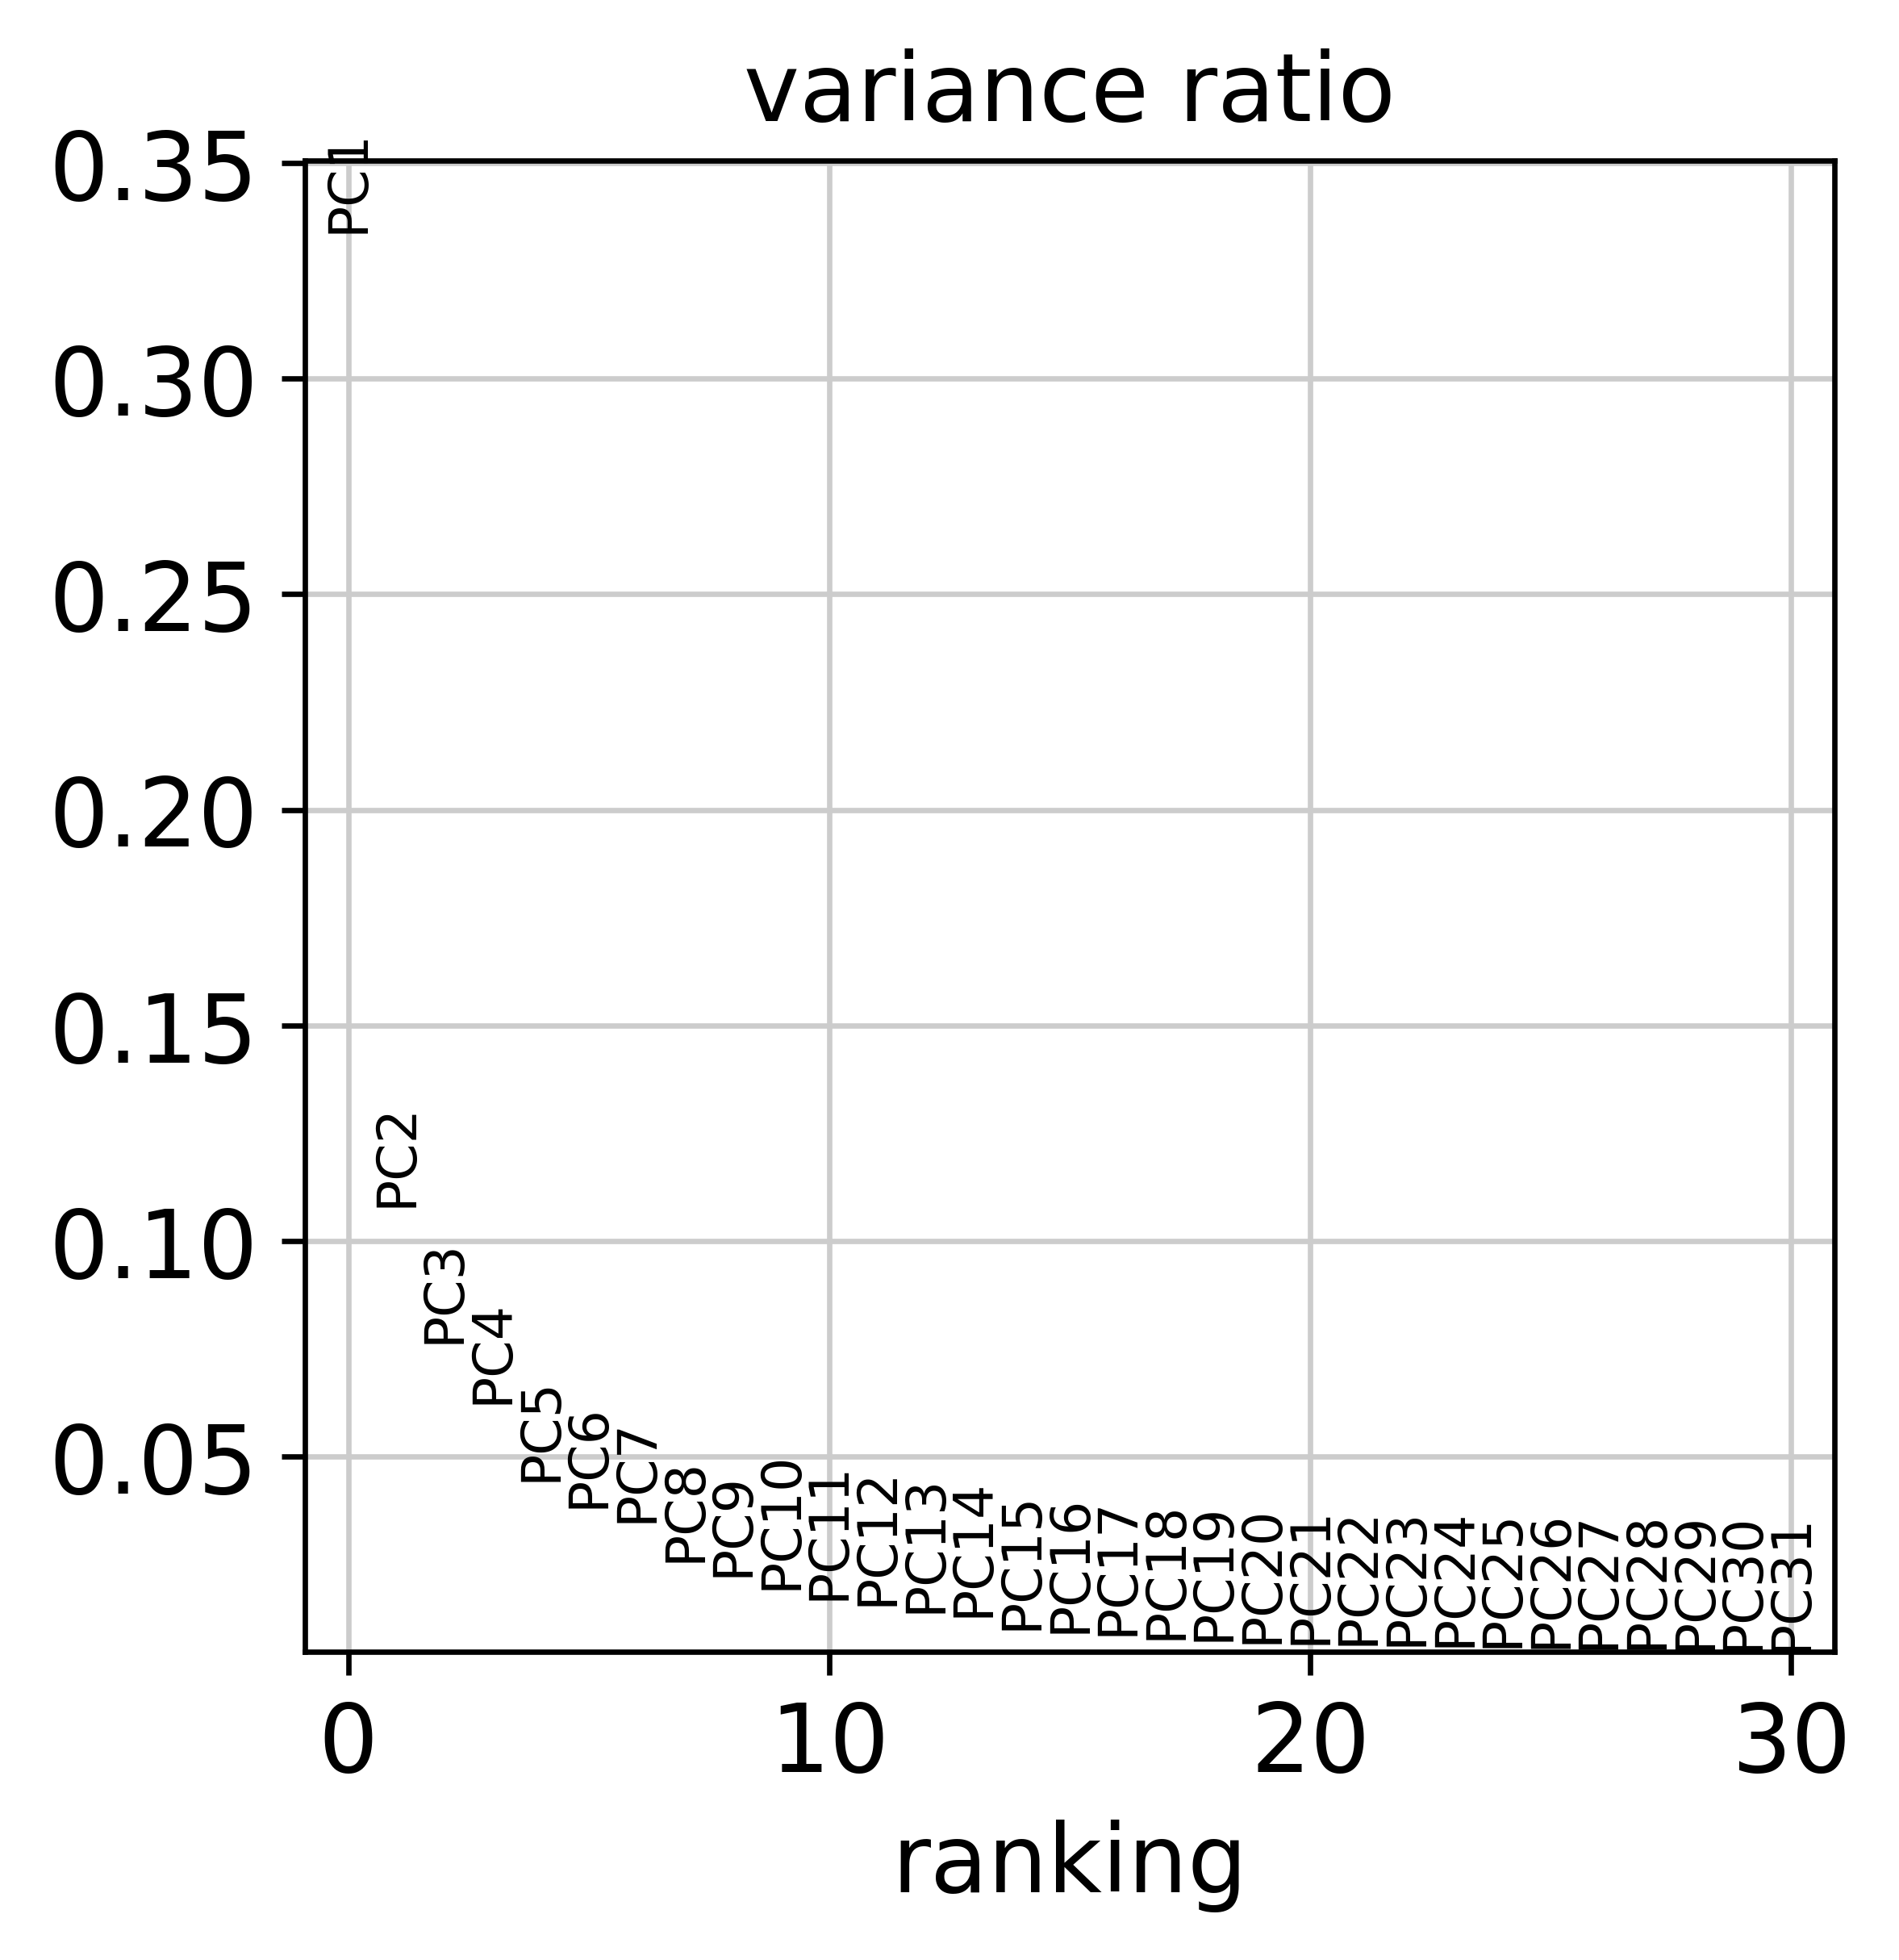

In [43]:
sc.pl.pca_variance_ratio(adata_fastmnn)

In [44]:
sc.pp.neighbors(adata_fastmnn,n_pcs=10)
sc.tl.umap(adata_fastmnn)

In [ ]:
sc.set_figure_params(dpi=300)
fig = sc.pl.umap(
    adata_fastmnn,  color=['cell_type', 'batch'],return_fig=True,legend_fontsize='xx-small',ncols=1)
fig.set_size_inches(8, 8)
fig.savefig("Integration_results_Lung/FastMNN.results.png", bbox_inches='tight')

In [46]:
adata_fastmnn.write_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/FastMNN_result.h5ad")

# Assess

In [47]:
adata_all = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/scANVI.h5ad")

In [48]:
adata_all

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', '_scvi_batch', '_scvi_labels'
    var: 'gene_symbol'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scANVI', 'X_scANVI_MDE', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [49]:
adata_merged = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/merged_result.h5ad")
adata_harmony = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/harmony.h5ad")
adata_bbknn = sc.read("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/BBKNN_result.h5ad")

/data1/chenyx/anaconda3/envs/scvi/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [50]:
adata_all.obsm['scVI'] = adata_all.obsm['X_scVI']
adata_all.obsm['scANVI'] = adata_all.obsm['X_scANVI']
adata_all.obsm['Seurat'] = adata_seurat.obsm['X_pca']
adata_all.obsm['FastMNN'] = adata_fastmnn.obsm['X_pca']
adata_all.obsm['harmony'] = adata_harmony.obsm['X_pca_harmony']
adata_all.obsm['umap_BBKNN'] = adata_bbknn.obsm['X_umap']
adata_all.obsm['raw'] = adata_merged.obsm['X_pca']

In [51]:
del adata_all.obsm['X_scANVI']
del adata_all.obsm['X_scANVI_MDE']
del adata_all.obsm['X_scVI']
del adata_all.obsm['X_umap']

In [54]:
adata_scgpt = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/scGPT_result.h5ad")

In [56]:
adata_all.obsm['X_scGPT'] = adata_scgpt.obsm['X_scGPT']

In [8]:
adata_scgpt_ZS = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/scGPT_without_finetune_result.h5ad")
adata_all.obsm['X_scGPT_zeroshot'] = adata_scgpt_ZS.obsm['X_scGPT']

In [9]:
adata_all

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', '_scvi_batch', '_scvi_labels'
    var: 'gene_symbol'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'FastMNN', 'Seurat', 'X_scGPT', 'harmony', 'raw', 'scANVI', 'scVI', 'umap_BBKNN', 'X_scGPT_zeroshot'
    obsp: 'connectivities', 'distances'

In [11]:
adata_all.write_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/all_methods.h5ad")

In [9]:
adata_all = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/all_methods.h5ad")

In [12]:
df = pd.read_csv("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/Geneformer6L_Lung.csv",index_col=0)
adata_all.obsm['geneformer'] = np.array(df)

In [13]:
adata_all.write_h5ad("/nfs/public/cell_gpt_data/Intergation_Data/Lung/Results/all_methods.h5ad")